# Caption Generation

This is a partial implementation of "Show and Tell: A Neural Image Caption Generator" (http://arxiv.org/abs/1411.4555), borrowing heavily from Andrej Karpathy's NeuralTalk (https://github.com/karpathy/neuraltalk)

### Output
This notebook samples from the trained network to generate captions given an input image.


### Prerequisites

To run this notebook, you'll need the trained GoogLeNet model, as well as the trained RNN model produced by the previous notebook

In [1]:
import sklearn
import numpy as np
import lasagne
import random
import skimage.transform

from lasagne.utils import floatX

import theano
import theano.tensor as T

import matplotlib.pyplot as plt
%matplotlib inline

import json
import pickle

In [2]:
from models import googlenet

In [3]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['pool5/7x7_s1']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [6]:
model_param_values = pickle.load(open('weights/blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

In [7]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

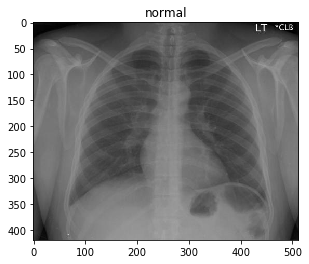

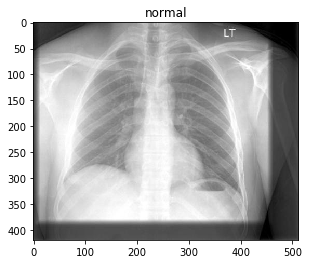

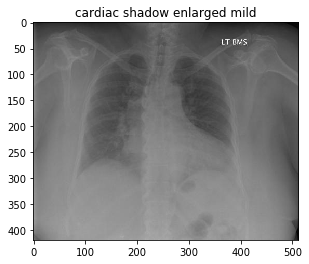

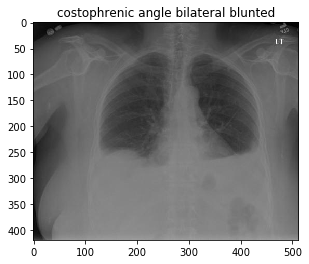

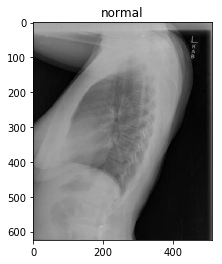

In [8]:
TEST_SIZE = 5

data = json.load(open('backups/all_reports_train_test_split.json'))
imagedir = 'jpeg_images/'
test_images = []

# return list of tuples (report, imageid) of test images
while len(test_images) < TEST_SIZE:
    item = random.choice(data)
    if item["split"] != "test":
        continue
    test_images.append((item["mesh caption"], item["imageid"]))

# plot images with corresponding reports
images = []
for caption, imid in test_images:
#     im = plt.imread(imagedir + imid + '.jpg')
#     plt.imshow(im)
    fn = imagedir + imid + '.jpg'
    try:
        plt.figure()
        plt.title(caption)
        image = plt.imread(fn)
        images.append(image)
        plt.imshow(image)
    except IOError:
        print("Error plotting image")
        continue


In [9]:
prepd_images = []
for im in images:
    rawim, cnn_im = prep_image(im)
    prepd_images.append((rawim, cnn_im))

/Users/Aydan/anaconda/envs/TheanoLasagne/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [10]:
CLASSES = pickle.load(open('weights/blvc_googlenet.pkl'))['synset words']
for im in prepd_images:
    p = get_cnn_features(im[1])
    print(CLASSES[p.argmax()])

bison
bison
bison
bison
thimble


In [17]:
#SEQUENCE_LENGTH = 32 # change when training on entire raw text
SEQUENCE_LENGTH = 11
MAX_SENTENCE_LENGTH = SEQUENCE_LENGTH - 3 # 1 for image, 1 for start token, 1 for end token
BATCH_SIZE = 1
CNN_FEATURE_SIZE = 1024
EMBEDDING_SIZE = 256

d = pickle.load(open('backups/lstm_chestx_trained.pkl'))
vocab = d['vocab']
word_to_index = d['word_to_index']
index_to_word = d['index_to_word']

In [18]:
l_input_sentence = lasagne.layers.InputLayer((BATCH_SIZE, SEQUENCE_LENGTH - 1))
l_sentence_embedding = lasagne.layers.EmbeddingLayer(l_input_sentence,
                                                     input_size=len(vocab),
                                                     output_size=EMBEDDING_SIZE,
                                                    )

l_input_cnn = lasagne.layers.InputLayer((BATCH_SIZE, CNN_FEATURE_SIZE))
l_cnn_embedding = lasagne.layers.DenseLayer(l_input_cnn, num_units=EMBEDDING_SIZE,
                                            nonlinearity=lasagne.nonlinearities.identity)

l_cnn_embedding = lasagne.layers.ReshapeLayer(l_cnn_embedding, ([0], 1, [1]))

l_rnn_input = lasagne.layers.ConcatLayer([l_cnn_embedding, l_sentence_embedding])
l_dropout_input = lasagne.layers.DropoutLayer(l_rnn_input, p=0.5)
l_lstm = lasagne.layers.LSTMLayer(l_dropout_input,
                                  num_units=EMBEDDING_SIZE,
                                  unroll_scan=True,
                                  grad_clipping=5.)
l_dropout_output = lasagne.layers.DropoutLayer(l_lstm, p=0.5)
l_shp = lasagne.layers.ReshapeLayer(l_dropout_output, (-1, EMBEDDING_SIZE))
l_decoder = lasagne.layers.DenseLayer(l_shp, num_units=len(vocab), nonlinearity=lasagne.nonlinearities.softmax)

l_out = lasagne.layers.ReshapeLayer(l_decoder, (BATCH_SIZE, SEQUENCE_LENGTH, len(vocab)))

In [19]:
lasagne.layers.set_all_param_values(l_out, d['param values'])

In [20]:
x_cnn_sym = T.matrix()
x_sentence_sym = T.imatrix()

output = lasagne.layers.get_output(l_out, {
                l_input_sentence: x_sentence_sym,
                l_input_cnn: x_cnn_sym
                })

f = theano.function([x_cnn_sym, x_sentence_sym], output)

In [21]:
def predict(x_cnn):
    x_sentence = np.zeros((BATCH_SIZE, SEQUENCE_LENGTH - 1), dtype='int32')
    words = []
    i = 0
    while True:
        i += 1
        p0 = f(x_cnn, x_sentence)
        pa = p0.argmax(-1)
        tok = pa[0][i]
        word = index_to_word[tok]
        if word == '#END#' or i >= SEQUENCE_LENGTH - 1:
            return ' '.join(words)
        else:
            x_sentence[0][i] = tok
            if word != '#START#':
                words.append(word)

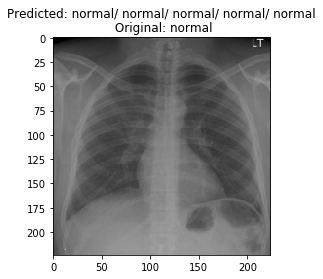

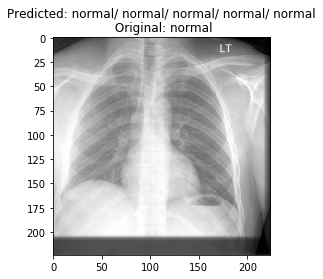

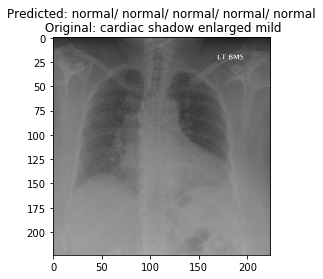

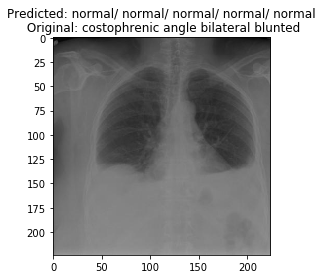

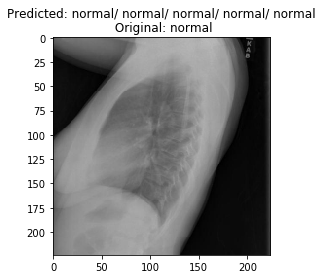

In [22]:
# Sample some predictions
prepd_images_arr = np.array(prepd_images)
test_images_arr = np.array(test_images)
for i in range(len(prepd_images_arr)):
    x_cnn = get_cnn_features(prepd_images_arr[i,1])
    predictions = []
    for _ in range(5):
        predictions.append(predict(x_cnn))
    plt.figure()
    plt.imshow(prepd_images_arr[i,0])
    plt.title("Predicted: " + "/ ".join(predictions) + "\n Original: " + test_images_arr[i,0])